# Data preprocessing

## Libraries

In [1]:
import os
import logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_svmlight_file
from tensorflow_serving.apis import input_pb2
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MaxAbsScaler

## Loading data

It is necessary to download the [dataset](https://www.microsoft.com/en-us/research/project/mslr/) manually and decompress it. We are using folder number one for this project, which contains three files (train, test, vali) in libSVM format and text extension.

Sklearn permits reading libSVM data and returns a sparse matrix for the features. We can easily transform it into a pandas dataframe. Labels and queries ids are numpy arrays.

In [2]:
def from_libsvm_pandas(data_path):
    #Load datasets in the svmlight / libsvm format into sparse CSR matrix
    matrix = load_svmlight_file(data_path, query_id=True) 
    features = pd.DataFrame.sparse.from_spmatrix(matrix[0])    
    return features, matrix[1], matrix[2]

In [3]:
X_train, y_train, query_id_train = from_libsvm_pandas('datasets/MSLR-WEB10K/train.txt') 
X_test, y_test, query_id_test = from_libsvm_pandas('datasets/MSLR-WEB10K/test.txt')
X_val, y_val, query_id_val = from_libsvm_pandas('datasets/MSLR-WEB10K/vali.txt')

In [4]:
display(X_train.head())

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.000000,0.0,1.0,...,62.0,11089534.0,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0
1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,54.0,11089534.0,2.0,124.0,64034.0,1.0,2.0,0.0,0.0,0.0
2,3.0,0.0,2.0,0.0,3.0,1.0,0.0,0.666667,0.0,1.0,...,45.0,3.0,1.0,124.0,3344.0,14.0,67.0,0.0,0.0,0.0
3,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,56.0,11089534.0,13.0,123.0,63933.0,1.0,3.0,0.0,0.0,0.0
4,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,64.0,5.0,7.0,256.0,49697.0,1.0,13.0,0.0,0.0,0.0


## Feature selection

According to a LASSO regression analysis in "Feature Selection and Model Comparison on Microsoft Learning-to-Rank Data Sets", certain features were found to have limited usefulness. Variance features and Inverse Document Frequency (IDF) based features appeared to be less effective in capturing the quality of web pages.

In [5]:
columns_to_remove = [40, 41, 42, 43, 44, 65, 66, 67, 68, 69,
                    90, 91, 92, 93, 94, 15, 16, 17, 18, 19,
                    70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                    80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

X_train = X_train.drop(columns=columns_to_remove)
X_test = X_test.drop(columns=columns_to_remove)
X_val = X_val.drop(columns=columns_to_remove)

In [6]:
print(X_train.shape)

(723412, 96)


This results in 96 columns since 40 features were removed for all datasets.

## Normalization

In contrast to Yahoo dataset, microsoft dataset's feature are not normalized (the values do not fall in the range 0 to 1) and this can reverberate the training. Therefore, we must apply a normalization technique.

Unfourtanetly, we cannot use min-max normalization when we have a sparse dataset. However, another option is MaxAbsScaler. It uses the maximum absolute value to perform the scaling, making it similar in nature to regular min-max normalization. Read more [here](https://github.com/christianversloot/machine-learning-articles/blob/main/feature-scaling-with-python-and-sparse-data.md).

In [7]:
scaler =  MaxAbsScaler()
X_train_d = scaler.fit_transform(X_train)
X_val_d = scaler.transform(X_val)
X_test_d = scaler.transform(X_test)

## Data visualization

To inspect the class balance of our three datasets, we can plot the labels' frequency.

### Frequency labels

In [8]:
def plot_frequency_labels(y_train, y_test, y_val):
    
    freq_train = np.bincount(y_train.astype(int))
    freq_test = np.bincount(y_test.astype(int))
    freq_val = np.bincount(y_val.astype(int))
    
    width = 0.3
    
    fig, ax = plt.subplots()
    labels = ["Bad", "Fair", "Good", "Excellent", "Perfect"]
    X_axis = np.arange(len(labels))
    
    ax.bar(X_axis, freq_train, width, label="Train", color='blue')
    ax.bar(X_axis+0.3, freq_val, width, label="Val", color='orange')
    ax.bar(X_axis+0.6, freq_test, width, label="Test", color='green')
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Label")
    ax.set_title("Counts by Label")
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.show()

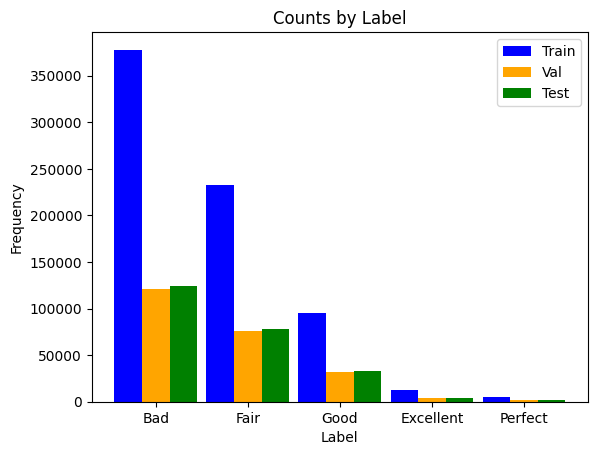

In [9]:
plot_frequency_labels(y_train, y_test, y_val)

The data is clearly imbalanced since most of the documents were labeled as "Bad", and not many as "Excellent" or "Perfect". However, this is common in real rankings since normally there are more irrelevant documents than relevant. It also depends on the person who puntuatets the document in light of the query. Therefore, we are not applying any treatment for imbalanced data.

### Frequency queries with # documents

Another interesting plot is the number of documents retrieved against the number of queries. 

In [10]:
def plot_frequency_queries_doc(qid_train, qid_test, qid_val):   
    
    
    # Count the frequencies for each number of documents returned
    num_docs_counts_train = np.bincount(np.bincount(qid_train), minlength=1)[1:]
    num_docs_counts_test = np.bincount(np.bincount(qid_test), minlength=1)[1:]
    num_docs_counts_val = np.bincount(np.bincount(qid_val), minlength=1)[1:]

    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    # Plot 1
    axs[0].bar(np.arange(len(num_docs_counts_train)),  num_docs_counts_train, color='blue')
    axs[0].set_ylabel('Number of Documents Returned')
    axs[0].set_xlabel('Number of Queries')
    axs[0].set_title('Train')

    # Plot 2
    axs[1].bar(np.arange(len(num_docs_counts_val)), num_docs_counts_val, color='orange')
    axs[1].set_ylabel('Number of Documents Returned')
    axs[1].set_xlabel('Number of Queries')
    axs[1].set_title('Val')

    # Plot 3
    axs[2].bar(np.arange(len(num_docs_counts_test)), num_docs_counts_test, color='green')
    axs[2].set_ylabel('Number of Documents Returned')
    axs[2].set_xlabel('Number of Queries')
    axs[2].set_title('Test')

    plt.tight_layout()
    plt.show()

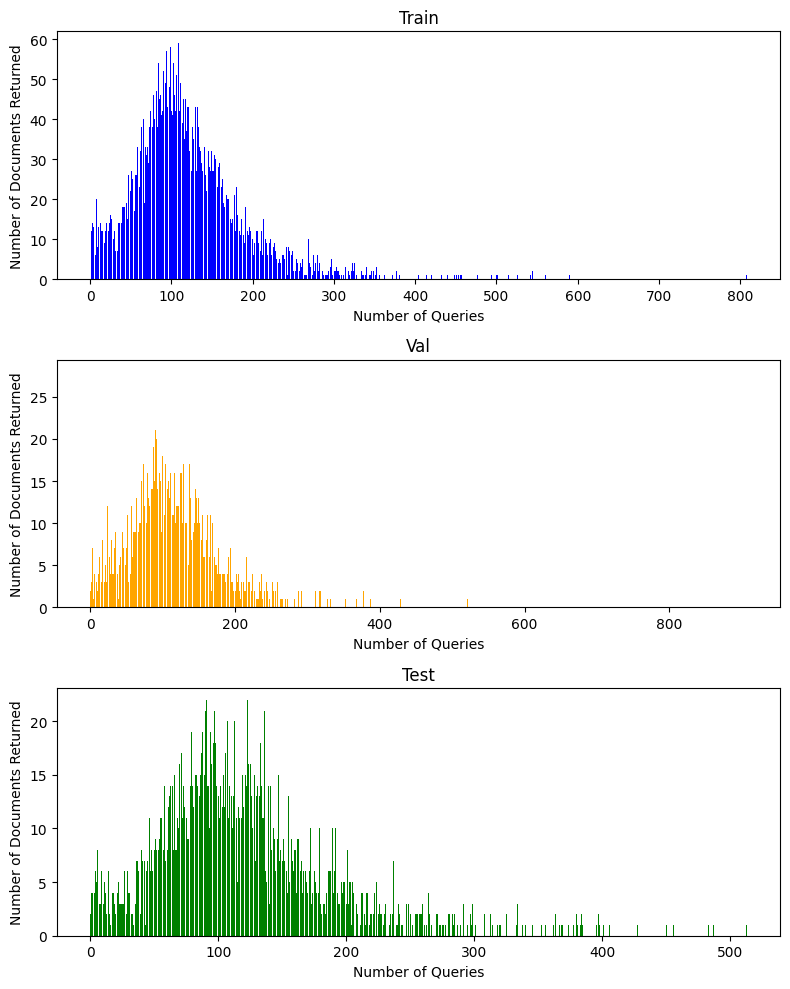

In [11]:
plot_frequency_queries_doc(query_id_train,query_id_test,query_id_val)

The sets follow a similar distribution. Most queries return between 70 and 200 documents. Hence, we are going to train our model using 150 documents per query.

### Printing statistic

In [12]:
def stats(train, test, val):
            
    # Collect metrics for below stats
    len_train = train[0].shape[0]
    len_test = test[0].shape[0]
    len_val = val[0].shape[0]
    total = len_train + len_test + len_val
        
    # Print length of all datasets and the overal balance between the splits
    print('*'*24 + ' ' + 'Total documents' + ' ' + '*'*24)
    print(f'Total documents in training set: {len_train}')
    print(f'Total documents in testing set: {len_test}')
    print(f'Total documents in validation set: {len_val}')
    print('='*64)
    print(f'The training set contains {round(len_train/total, 3)}% of the total data')
    print(f'The testing set contains {round(len_test/total, 3)}% of the total data')
    print(f'The validation set contains {round(len_val/total, 3)}% of the total data')
         
    # Mapping of initial dataframes
    dataframes = {'train': train, 'test': test, 'val': val}
        
    # Calculating the distribution of the relevance column
    for k,df in dataframes.items():
        len_docs = len(df[1])
        relevance_counts = np.bincount(df[1].astype(int))
        print('='*64)
        print('*'*16 + ' ' + f'{k} Relevance Class Balance' + ' ' + '*'*16)
        for i in [0,1,2,3,4]:
            print(f'Rank {i}: Total Count: {relevance_counts[i]} Percentage: {round(relevance_counts[i]/len_docs,3)}')
    print(' ')

In [13]:
train = [X_train_d, y_train, query_id_train]
test = [X_test_d, y_test, query_id_test]
val = [X_val_d, y_val, query_id_val]

stats(train, test, val)

************************ Total documents ************************
Total documents in training set: 723412
Total documents in testing set: 241521
Total documents in validation set: 235259
The training set contains 0.603% of the total data
The testing set contains 0.201% of the total data
The validation set contains 0.196% of the total data
**************** train Relevance Class Balance ****************
Rank 0: Total Count: 377957 Percentage: 0.522
Rank 1: Total Count: 232569 Percentage: 0.321
Rank 2: Total Count: 95082 Percentage: 0.131
Rank 3: Total Count: 12658 Percentage: 0.017
Rank 4: Total Count: 5146 Percentage: 0.007
**************** test Relevance Class Balance ****************
Rank 0: Total Count: 124784 Percentage: 0.517
Rank 1: Total Count: 77896 Percentage: 0.323
Rank 2: Total Count: 32459 Percentage: 0.134
Rank 3: Total Count: 4450 Percentage: 0.018
Rank 4: Total Count: 1932 Percentage: 0.008
**************** val Relevance Class Balance ****************
Rank 0: Total Count:

## Save as tfrecords

Finally, it is necessary to save the data in a specific format known as ELWC if we want to train a neural GAM model. It is one of the accepted formats of tensorflow ranking library.

In [14]:
class Parser_libSVM_tfrecord():
    
    def __init__(self, data=[], tfrecord_path=' ', labels = []):
        
        self.data = data
        self.tfrecord_path = tfrecord_path
        self.labels = labels
        
        if not os.path.isdir(self.tfrecord_path):
            os.makedirs(self.tfrecord_path)
            
    def _float_feature(self, value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    def create_tfrecord(self, data, tfrecord_path):

        options_ = tf.io.TFRecordOptions(compression_type='GZIP')
        with tf.io.TFRecordWriter(tfrecord_path) as writer:

            # Create Example list 
            elwc = input_pb2.ExampleListWithContext()
            # Save the last query id for filtering
            last_query_id = None
            
            #for each sample
            for row in range(data.shape[0]):
                # Select data from each row
                relevance_label, query_id, features = data[row,0],data[row,1],data[row,2:]
                # Create Example Dict
                example_dict = {
                   f'{feat_name}':self._float_feature(feat_val) for feat_name, feat_val in zip(self.labels, features)
                }
                example_dict['relevance_label'] = self._int64_feature(int(relevance_label))
                # Create Features
                example_ = tf.train.Example(features=tf.train.Features(
                                                         feature=example_dict)
                                     )
                # Create ELWC by query id
                if query_id != last_query_id:
                    if last_query_id != None:
                        writer.write(elwc.SerializeToString())
                    last_query_id = query_id
                    elwc = input_pb2.ExampleListWithContext()
                    elwc.examples.append(example_)
                else:
                    elwc.examples.append(example_)
            # Writing the final query
            writer.write(elwc.SerializeToString())
            
    def load_and_convert_data(self):
        # Concatenate data into one array
        # each row represents a doc, and the columns contain the label, query ID, and features
        for label, dataset in data.items():
            
            expanded_data = np.concatenate((np.expand_dims(dataset[1], axis=1), 
                                        np.expand_dims(dataset[2], axis=1), 
                                        dataset[0].toarray()), axis=1)
            tfrecord_path = f'{self.tfrecord_path}/{label}.tfrecords' 
            self.create_tfrecord(expanded_data, tfrecord_path) #call function to transform into tfrecord

In [15]:
mslr_labels = ['covered_query_term_number_body','covered_query_term_number_anchor','covered_query_term_number_title', 
                 'covered_query_term_number_url','covered_query_term_number_whole_document','covered_query_term_ratio_body',
                'covered_query_term_ratio_anchor','covered_query_term_ratio_title','covered_query_term_ratio_url',
                 'covered_query_term_ratio_whole_document', 'stream_length_body', 'stream_length_anchor',
                'stream_length_title','stream_length_url','stream_length_whole_document','sum_term_freq_body','sum_term_freq_anchor','sum_term_freq_title',
                 'sum_term_freq_url','sum_term_freq_whole_document','min_term_freq_body','min_term_freq_anchor','min_term_freq_title',
                 'min_term_freq_url','min_term_freq_whole_document','max_term_freq_body','max_term_freq_anchor','max_term_freq_title',
                 'max_term_freq_url','max_term_freq_whole_document','mean_term_freq_body','mean_term_freq_anchor','mean_term_freq_title',
                 'mean_term_freq_url','mean_term_freq_whole_document','sum_stream_length_normalized_term_freq_body','sum_stream_length_normalized_term_freq_anchor',
                 'sum_stream_length_normalized_term_freq_title','sum_stream_length_normalized_term_freq_url','sum_stream_length_normalized_term_whole_document',
                 'min_stream_length_normalized_term_freq_body','min_stream_length_normalized_term_freq_anchor','min_stream_length_normalized_term_freq_title',
                 'min_stream_length_normalized_term_freq_url','min_stream_length_normalized_term_freq_whole_document','max_stream_length_normalized_term_freq_body',
                 'max_stream_length_normalized_term_freq_anchor','max_stream_length_normalized_term_freq_title','max_stream_length_normalized_term_freq_url',
                 'max_stream_length_normalized_term_freq_whole_document','mean_stream_length_normalized_term_freq_body','mean_stream_length_normalized_term_freq_anchor',
                 'mean_stream_length_normalized_term_freq_title','mean_stream_length_normalized_term_freq_url','mean_stream_length_normalized_term_freq_whole_document','boolean_model_body',
                 'boolean_model_anchor','boolean_model_title','boolean_model_url','boolean_model_whole_document','vector_space_model_body',
                 'vector_space_model_anchor','vector_space_model_title','vector_space_model_url','vector_space_model_whole_document','BM25_body',
                 'BM25_anchor','BM25_title','BM25_url','BM25_whole_document','LMIR.ABS_body','LMIR.ABS_anchor','LMIR.ABS_title','LMIR.ABS_url',
                 'LMIR.ABS_whole_document','LMIR.DIR_body','LMIR.DIR_anchor','LMIR.DIR_title','LMIR.DIR_url','LMIR.DIR_whole_document','LMIR.JM_body',
                 'LMIR.JM_anchor','LMIR.JM_title','LMIR.JM_url','LMIR.JM_whole_document','num_slash_url','length_url','inlink_number','outlink_number',
                 'pagerank','siterank','qualityscore','qualityscore2','query_url_click_count','url_click_count','url_dwell_time']

In [16]:
data = {'train':train, 'test':test, 'val':val}

parser = Parser_libSVM_tfrecord(data=data, tfrecord_path='datasets/MSLR-WEB10K/tfrecords', labels = mslr_labels)
parser.load_and_convert_data()

## Save test data as CSV

We also save the test data as a csv because we will need it later when we want to use LIME to generate explanations.

In [17]:
final_df = pd.DataFrame.sparse.from_spmatrix(test[0], columns = mslr_labels)
final_df.insert(0, 'qid', test[2])
final_df.insert(0, 'relevance_label', test[1])

In [18]:
display(final_df.head())

,relevance_label,qid,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,length_url,inlink_number,outlink_number,pagerank,siterank,qualityscore,qualityscore2,query_url_click_count,url_click_count,url_dwell_time
0,2.0,13,0.026667,0.0,0.133333,0.066667,0.026667,1.0,0.0,1.0,...,0.022595,4.798976e-10,0.0,0.004059,0.382544,0.110236,0.027559,0.0,0.0,0.0
1,1.0,13,0.026667,0.0,0.000000,0.000000,0.026667,1.0,0.0,0.0,...,0.010975,4.463047e-08,0.0,0.002335,0.196231,0.255906,0.622047,0.0,0.0,0.0
2,3.0,13,0.026667,0.0,0.066667,0.000000,0.026667,1.0,0.0,0.5,...,0.012266,0.000000e+00,0.0,0.002335,0.017258,0.440945,0.555118,0.0,0.0,0.0
3,1.0,13,0.026667,0.0,0.133333,0.066667,0.026667,1.0,0.0,1.0,...,0.032279,3.924362e-05,0.0,0.008545,0.934218,0.003937,0.055118,0.0,0.0,0.0
4,0.0,13,0.013333,0.0,0.000000,0.000000,0.013333,0.5,0.0,0.0,...,0.015494,0.000000e+00,0.0,0.884320,0.238041,0.059055,0.047244,0.0,0.0,0.0


In [19]:
final_df.to_csv('test_mslr.csv', index=False)